In [2]:
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
!pip install pycalculix

     |████████████████████████████████| 92kB 4.7MB/s 
  Created wheel for pycalculix: filename=pycalculix-1.1.4-cp37-none-any.whl size=81884 sha256=037ac0ed82a8c2c4fead59d53783463bd79f5ebd12bb744418618ba08a80bdda
  Stored in directory: /root/.cache/pip/wheels/1a/c2/7c/7cbf8acf9d940a9472e4c9faf2cdb36b4bb899af01ae98d23e
Successfully built pycalculix


In [ ]:
!pycalculix-add-feaprograms

Detected Linux 64 bit
Installing gmsh
Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following additional packages will be installed:
  gmsh-doc libcgns3.3 libfltk-gl1.3 libfltk-images1.3 libfltk1.3 libgmsh3
  libmed1v5 liboce-foundation11 liboce-modeling11 libtet1.5
Suggested packages:
  libmed-doc libmed-tools
The following NEW packages will be installed:
  gmsh gmsh-doc libcgns3.3 libfltk-gl1.3 libfltk-images1.3 libfltk1.3 libgmsh3
  libmed1v5 liboce-foundation11 liboce-modeling11 libtet1.5
0 upgraded, 11 newly installed, 0 to remove and 29 not upgraded.
Need to get 21.9 MB of archives.
After this operation, 71.9 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 libcgns3.3 amd64 3.3.0-5 [233 kB]
Get:2 http://archive.ubuntu.com/ubuntu bionic/universe amd64 libfltk1.3 amd64 1.3.4-6 [523 kB]
Get:3 http://archive.ubuntu.com/ubuntu bionic/universe amd64 libfltk-gl1.3 amd64 1.3.4-6 [3

In [ ]:
# this is from examples/hole-in-plate-full.py
import pycalculix as pyc

# Vertical hole in plate model, make model
proj_name = 'hole-in-plate-full'
model = pyc.FeaModel(proj_name)
model.set_units('m') # this sets dist units to meters

# Define variables we'll use to draw part geometry
diam = 2.0 # hole diam
ratio = 0.45
width = diam/ratio   #plate width
print('D=%f, H=%f, D/H=%f' % (diam, width, diam/width))
length = 2*width  #plate length

# Draw part geometry, you must draw the part CLOCKWISE, x, y = radial, axial
part = pyc.Part(model)
part.goto(length*0.5, -width*0.5)
part.draw_line_ax(width)
part.draw_line_rad(-length)
part.draw_line_ax(-width)
part.draw_line_rad(length)
hole_lines = part.draw_hole(0, 0, diam*0.5, filled=False)
model.set_ediv(hole_lines, 10)
part.chunk()
model.plot_geometry(proj_name+'_geom') # view the geometry

# set loads and constraints
pressure = 1000
model.set_load('press', part.top, pressure)
model.set_load('press', part.bottom, pressure)
model.set_constr('fix', ['P6', 'P8'], 'y')
model.set_constr('fix', ['P4', 'P7'], 'x')

# set part material
mat = pyc.Material('steel')
mat.set_mech_props(7800, 210*(10**9), 0.3)
model.set_matl(mat, part)

# set the element type and mesh database
model.set_eshape('quad', 2)
model.set_etype('plstress', part, 0.1)
model.mesh(1.0, 'gmsh') # mesh 1.0 fineness, smaller is finer
model.plot_elements(proj_name+'_elem')   # plot part elements
model.plot_pressures(proj_name+'_press')
model.plot_constraints(proj_name+'_constr')

# make and solve the model
prob = pyc.Problem(model, 'struct')
prob.solve()

# view and query results
sx = prob.rfile.get_nmax('Sx')
print('Sx_max: %f' % sx)

# Plot results
fields = 'Sx,Sy,S1,S2,S3,Seqv,ux,uy,utot,ex'    # store the fields to plot
fields = fields.split(',')
for field in fields:
    fname = proj_name+'_'+field
    prob.rfile.nplot(field, fname, display=False)

ModuleNotFoundError: ignored

In [3]:
def stress_transformation(xx, yy, zz, taoyz, taozx, taoxy, beta1, alpha1, beta2, alpha2):
  import numpy as np

  sigma = np.array([[xx],
                    [yy],
                    [zz],
                    [taoyz],
                    [taozx],
                    [taoxy]])

  beta1 = beta1 * np.pi / 180
  alpha1 = alpha1 * np.pi / 180
  beta2 = beta2 * np.pi / 180
  alpha2 = alpha2 * np.pi / 180

  # sigma_borehole=O*R'*sigma
  lxa = np.cos(beta1) * np.cos(alpha1)
  mxa = np.cos(beta1) * np.sin(alpha1)
  nxa = -np.sin(beta1)
  lya = -np.sin(alpha1)
  mya = np.cos(alpha1)
  nya = 0
  lza = np.sin(beta1) * np.cos(alpha1)
  mza = np.sin(beta1) * np.sin(alpha1)
  nza = np.cos(beta1)

  O = np.array([[lxa**2, mxa**2, nxa**2, 2 * mxa * nxa, 2 * nxa * lxa, 2 * lxa * mxa],
                [lya**2, mya**2, nya**2, 2 * mya * nya, 2 * nya * lya, 2 * lya * mya],
                [lza**2, mza**2, nza**2, 2 * mza * nza, 2 * nza * lza, 2 * lza * mza],
                [lya * lza, mya * mza, nya * nza, mya * nza + mza * nya, nya * lza + nza * lya, lya * mza + lza * mya],
                [lza * lxa, mza * mxa, nza * nxa, mxa * nza + mza * nxa, nxa * lza + nza * lxa, lxa * mza + lza * mxa],
                [lxa * lya, mxa * mya, nxa * nya, mxa * nya + mya * nxa, nxa * lya + nya * lxa, lxa * mya + lya * mxa]])

  lx = np.cos(beta2) * np.cos(alpha2)
  mx = np.cos(beta2) * np.sin(alpha2)
  nx = -np.sin(beta2)
  ly = -np.sin(alpha2)
  my = np.cos(alpha2)
  ny = 0
  lz = np.sin(beta2) * np.cos(alpha2)
  mz = np.sin(beta2) * np.sin(alpha2)
  nz = np.cos(beta2)

  R = np.array([[lx**2 ,mx**2, nx**2, mx * nx, nx * lx, lx * mx],
                [ly**2, my**2, ny**2, my * ny, ny * ly, ly * my],
                [lz**2, mz**2, nz**2, mz * nz, nz * lz, lz * mz],
                [2 * ly * lz, 2 * my * mz, 2 * ny * nz, my * nz + mz * ny, ny * lz + nz * ly, ly * mz + lz * my],
                [2 * lz * lx, 2 * mz * mx, 2 * nz * nx, mx * nz + mz * nx, nx * lz + nz * lx, lx * mz + lz * mx],
                [2 * lx * ly, 2 * mx * my, 2 * nx * ny, mx * ny + my * nx, nx * ly + ny * lx, lx * my + ly * mx]])

  O[abs(O) < pow(10,-10)] = 0
  R[abs(R) < pow(10,-10)] = 0

  sigma_borehole = O @ R.T @ sigma # @ here is dot product

  return sigma_borehole

In [6]:
def compliance_transformation(beta1, alpha1, beta2, alpha2, Compliance):
  import numpy as np

  beta1 = beta1 * np.pi / 180
  alpha1 = alpha1 * np.pi / 180
  beta2 = beta2 * np.pi / 180
  alpha2 = alpha2 * np.pi / 180

  # direction cosines of the unit vector in the rectilinear anisotropy
  lxa = np.cos(beta1) * np.cos(alpha1)
  mxa = np.cos(beta1) * np.sin(alpha1)
  nxa = -np.sin(beta1)
  lya = -np.sin(alpha1)
  mya = np.cos(alpha1)
  nya = 0
  lza = np.sin(beta1) * np.cos(alpha1)
  mza = np.sin(beta1) * np.sin(alpha1)
  nza = np.cos(beta1)

  T1 = np.array([[lxa**2, mxa**2, nxa**2, 2 * mxa * nxa, 2 * nxa * lxa, 2 * lxa * mxa],
                 [lya**2, mya**2, nya**2, 2 * mya * nya, 2 * nya * lya, 2 * lya * mya],
                 [lza**2, mza**2, nza**2, 2 * mza * nza, 2 * nza * lza, 2 * lza * mza],
                 [lya * lza, mya * mza, nya * nza, mya * nza + mza * nya, nya * lza + nza * lya, lya * mza + lza * mya],
                 [lza * lxa, mza * mxa, nza * nxa, mxa * nza + mza * nxa, nxa * lza + nza * lxa, lxa * mza + lza * mxa],
                 [lxa * lya, mxa * mya, nxa * nya, mxa * nya + mya * nxa, nxa * lya + nya * lxa, lxa * mya + lya * mxa]])

  # direction cosines of the unit vector in the borehole coordinate
  lx = np.cos(beta2) * np.cos(alpha2)
  mx = np.cos(beta2) * np.sin(alpha2)
  nx = -np.sin(beta2)
  ly = -np.sin(alpha2)
  my = np.cos(alpha2)
  ny = 0
  lz = np.sin(beta2) * np.cos(alpha2)
  mz = np.sin(beta2) * np.sin(alpha2)
  nz = np.cos(beta2)

  T2 = np.array([[lx**2 ,mx**2, nx**2, mx * nx, nx * lx, lx * mx],
                 [ly**2, my**2, ny**2, my * ny, ny * ly, ly * my],
                 [lz**2, mz**2, nz**2, mz * nz, nz * lz, lz * mz],
                 [2 * ly * lz, 2 * my * mz, 2 * ny * nz, my * nz + mz * ny, ny * lz + nz * ly, ly * mz + lz * my],
                 [2 * lz * lx, 2 * mz * mx, 2 * nz * nx, mx * nz + mz * nx, nx * lz + nz * lx, lx * mz + lz * mx],
                 [2 * lx * ly, 2 * mx * my, 2 * nx * ny, mx * ny + my * nx, nx * ly + ny * lx, lx * my + ly * mx]])

  T1[abs(T1) < pow(10,-10)] = 0
  T2[abs(T2) < pow(10,-10)] = 0

  A = T2 @ (T1.T) @ Compliance @ T1 @ (T2.T)

  return A

In [7]:
a = 1
taoxy0 = 0
taoxz0 = 0
taoyz0 = 0
c11 = 33.20
c13 = 4.98
c33 = 22.184
c44 = 10.906
c66 = 14.60
sigmax0 = 1
sigmay0 = 0
sigmaz0 = 0
pw = 0

# stress transformation
stress = stress_transformation(sigmax0, sigmay0, sigmaz0, taoyz0, taoxz0, taoxy0,
                               60, 0, 0, 0)

# ATTENTION: the borehole angle in this part should be the same as the later
# one when you transform the compliance matrix.
sigmax0 = stress[0]
sigmay0 = stress[1]
sigmaz0 = stress[2]
taoxy0 = stress[5]
taoxz0 = stress[4]
taoyz0 = stress[3]

# elastic constants
c12 = c11 - 2 * c66
c22 = c11
c23 = c13

S = np.array([[c11,  c12,  c13,  0,  0,  0],
             [c12,  c22,  c23,  0,  0,  0],
             [c13,  c23,  c33,  0,  0,  0],
             [0,    0,    0,    c44,0,  0],
             [0,    0,    0,    0,  c44,0],
             [0,    0,    0,    0,  0,  c66]])

A1 = np.linalg.inv(S)
A = compliance_transformation(0, 0, 60, 0, A1) # rectilinear anisotropy symmetry

# plane is horizontal and the borehole is horizontal as well.
a11 = A[0,0]
a12 = A[0,1]
a13 = A[0,2]
a21 = A[1,0]
a22 = A[1,1]
a23 = A[1,2]
a33 = A[2,2]
a34 = A[2,3]
a35 = A[2,4]
a36 = A[2,5]
a44 = A[3,3]
a66 = A[5,5]

# beta
beta55 = A[4,4] - (A[4,2] * A[4,2]) / a33
beta45 = A[3,4] - (A[3,2] * A[4,2]) / a33
beta44 = A[3,3] - (A[3,2] * A[3,2]) / a33
beta11 = A[0,0] - (A[0,2] * A[0,2]) / a33
beta16 = A[0,5] - (A[0,2] * A[5,2]) / a33
beta12 = A[0,1] - (A[0,2] * A[1,2]) / a33
beta66 = A[5,5] - (A[5,2] * A[5,2]) / a33
beta26 = A[1,5] - (A[1,2] * A[5,2]) / a33
beta22 = A[1,1] - (A[1,2] * A[1,2]) / a33
beta15 = A[0,4] - (A[0,2] * A[4,2]) / a33
beta14 = A[0,3] - (A[0,2] * A[3,2]) / a33
beta56 = A[4,5] - (A[4,2] * A[5,2]) / a33
beta25 = A[1,4] - (A[1,2] * A[4,2]) / a33
beta46 = A[3,5] - (A[3,2] * A[5,2]) / a33
beta24 = A[1,3] - (A[1,2] * A[3,2]) / a33

# miu1 & miu2
p1 = np.array([beta55, -2 * beta45, beta44])
p2 = np.array([beta11, -2 * beta16, (2 * beta12 + beta66), -2 * beta26, beta22])
miu11 = np.roots(p1)
miu22 = np.roots(p2)
miu3 = miu11[0]
miu1 = miu22[0]
miu2 = miu22[2]

# lamda1 2 3
l2_miu1 = beta55 * miu1**2 - 2 * beta45 * miu1 + beta44
l2_miu2 = beta55 * miu2**2 - 2 * beta45 * miu2 + beta44
l2_miu3 = beta55 * miu3**2 - 2 * beta45 * miu3 + beta44
l3_miu1 = beta15 * miu1**3 - (beta14 + beta56) * miu1**2 + (beta25 + beta46) * miu1 - beta24
l3_miu2 = beta15 * miu2**3 - (beta14 + beta56) * miu2**2 + (beta25 + beta46) * miu2 - beta24
l3_miu3 = beta15 * miu3**3 - (beta14 + beta56) * miu3**2 + (beta25 + beta46) * miu3 - beta24

if l2_miu1 == 0:
  lamda1 = 0
else:
  lamda1 = -l3_miu1 / l2_miu1

if l2_miu2 == 0:
  lamda2 = 0
else:
  lamda2 = -l3_miu2 / l2_miu2

if l2_miu3 == 0:
  lamda3 = 0
else:
  lamda3 = -l3_miu3 / l2_miu3

# triangle
triangle = miu2 - miu1 + lamda2 * lamda3 * (miu1 - miu3) + lamda1 * lamda3 * (miu3 - miu2)

X1 = np.linspace(0, 5, 1001)
Y1 = np.linspace(-5, 5, 2002)
[x,y] = np.meshgrid(X1, Y1)

for jj in range(len(Y1)):
  for vv in range(len(X1)):
    r = ((x[jj,vv])**2 + (y[jj,vv])**2)
    if r < a:
      x[jj,vv] = np.nan
      y[jj,vv] = np.nan

    if x[jj,vv] == 0: # when x=0 or y=0, it is not stable. So, it's get rid of.
      x[jj,vv] = np.nan
      y[jj,vv] = np.nan

sigmax = np.zeros([2002,2002])
sigmay = np.zeros([2002,2002])
sigmaz = np.zeros([2002,2002])
taoxy = np.zeros([2002,2002])
taoxz = np.zeros([2002,2002])
taoyz = np.zeros([2002,2002])
hoop = np.zeros([2002,2002])
radial = np.zeros([2002,2002])
z1 = x + miu1 * y
z2 = x + miu2 * y
z3 = x + miu3 * y
eta1 = (z1 / a + ((z1 / a)**2 - 1 - miu1**2)**0.5) / (1 - 1j * miu1)

eta2 = (z2 / a + ((z2 / a)**2 - 1 - miu2**2)**0.5) / (1 - 1j * miu2)
eta3 = (z3 / a + ((z3 / a)**2 - 1 - miu3**2)**0.5) / (1 - 1j * miu3)
phi1 = -(1 / (2 * triangle * eta1 * ((z1 / a)**2 - 1 - miu1**2)**0.5)) * ((1j * taoxy0 - sigmay0 + pw) * (miu2 - lamda2 * lamda3 * miu3) + (taoxy0 - 1j * sigmax0 + 1j * pw) * (lamda2 * lamda3 - 1) + (taoyz0 - 1j * taoxz0) * lamda3 * (miu3 - miu2))
phi2 = -(1 / (2 * triangle * eta2 * ((z2 / a)**2 - 1 - miu2**2)**0.5)) * ((1j * taoxy0 - sigmay0 + pw) * (lamda1 * lamda3 * miu3 - miu1) + (taoxy0 - 1j * sigmax0 + 1j * pw) * (1 - lamda1 * lamda3) + (taoyz0 - 1j * taoxz0) * lamda3 * (miu1 - miu3))
phi3 = -(1 / (2 * triangle * eta3 * ((z3 / a)**2 - 1 - miu3**2)**0.5)) * ((1j * taoxy0 - sigmay0 + pw) * (lamda2 * miu1 - lamda1 * miu2) + (taoxy0 - 1j * sigmax0 + 1j * pw) * (lamda1 - lamda2) + (taoyz0 - 1j * taoxz0) * (miu2 - miu1))

sigmax[0:2002,1001:2002] = sigmax0 + 2 * np.real(miu1**2 * phi1 + miu2**2 * phi2 + lamda3 * miu3**2 *phi3)
sigmay[0:2002,1001:2002] = sigmay0 + 2 * np.real(phi1 + phi2 + lamda3 * phi3)
taoxy[0:2002,1001:2002] = taoxy0 - 2 * np.real(miu1 * phi1 + miu2 * phi2 + lamda3 * miu3 * phi3)
taoxz[0:2002,1001:2002] = taoxz0 + 2 * np.real(lamda1 * miu1 * phi1 + lamda2 * miu2 * phi2 + miu3 * phi3)
taoyz[0:2002,1001:2002] = taoyz0 - 2 * np.real(lamda1 * phi1 + lamda2 * phi2 + phi3)
sigmaz[0:2002,1001:2002] = sigmaz0 - (a13 * 2 * np.real((miu1**2) * phi1 + (miu2**2) * phi2 + lamda3 * miu3**2 * phi3) + a23 * (2 * np.real(phi1 + phi2 + lamda3 * phi3)) + a34 * (-2 * np.real(lamda1 * phi1 + lamda2 * phi2 + phi3)) + a35 * (2 * np.real(lamda1 * miu1 * phi1 + lamda2 * miu2 *phi2 + miu3 * phi3)) + a36 * (-2 * np.real(miu1 * phi1 + miu2 * phi2 + lamda3 * miu3 * phi3))) / a33

theta = np.arctan2(y, x)

hoop[0:2002,1001:2002] = (np.sin(theta))**2 * sigmax[0:2002,1001:2002] + (np.cos(theta))**2 * sigmay[0:2002,1001:2002] - np.sin(2 * theta) * taoxy[0:2002,1001:2002]
radial[0:2002,1001:2002]=sigmax[0:2002,1001:2002] * (np.cos(theta))**2 + (np.sin(theta))**2 * sigmay[0:2002,1001:2002] + np.sin(2 * theta) * taoxy[0:2002,1001:2002]


# another half
X2 = np.linspace(-5, 0, 1001)
Y2 = np.linspace(-5, 5, 2002)
[x,y] = np.meshgrid(X1, Y1)

for jj in range(len(Y2)):
  for vv in range(len(X2)):
    r = ((x[jj,vv])**2 + (y[jj,vv])**2)
    if r < a:
      x[jj,vv] = np.nan
      y[jj,vv] = np.nan

    if x[jj,vv] == 0: # when x=0 or y=0, it is not stable. So, to get rid of.
      x[jj,vv] = np.nan
      y[jj,vv] = np.nan

z1 = x + miu1 * y
z2 = x + miu2 * y
z3 = x + miu3 * y
eta1 = (z1 / a + ((z1 / a)**2 - 1 - miu1**2)**0.5) / (1 - 1j * miu1)

eta2 = (z2 / a + ((z2 / a)**2 - 1 - miu2**2)**0.5) / (1 - 1j * miu2)
eta3 = (z3 / a + ((z3 / a)**2 - 1 - miu3**2)**0.5) / (1 - 1j * miu3)
phi1 = -(1 / (2 * triangle * eta1 * ((z1 / a)**2 - 1 - miu1**2)**0.5)) * ((1j * taoxy0 - sigmay0 + pw) * (miu2 - lamda2 * lamda3 * miu3) + (taoxy0 - 1j * sigmax0 + 1j * pw) * (lamda2 * lamda3 - 1) + (taoyz0 - 1j * taoxz0) * lamda3 * (miu3 - miu2))
phi2 = -(1 / (2 * triangle * eta2 * ((z2 / a)**2 - 1 - miu2**2)**0.5)) * ((1j * taoxy0 - sigmay0 + pw) * (lamda1 * lamda3 * miu3 - miu1) + (taoxy0 - 1j * sigmax0 + 1j * pw) * (1 - lamda1 * lamda3) + (taoyz0 - 1j * taoxz0) * lamda3 * (miu1 - miu3))
phi3 = -(1 / (2 * triangle * eta3 * ((z3 / a)**2 - 1 - miu3**2)**0.5)) * ((1j * taoxy0 - sigmay0 + pw) * (lamda2 * miu1 - lamda1 * miu2) + (taoxy0 - 1j * sigmax0 + 1j * pw) * (lamda1 - lamda2) + (taoyz0 - 1j * taoxz0) * (miu2 - miu1))

sigmax[0:2002,0:1001] = sigmax0 + 2 * np.real(miu1**2 * phi1 + miu2**2 * phi2 + lamda3 * miu3**2 *phi3)
sigmay[0:2002,0:1001] = sigmay0 + 2 * np.real(phi1 + phi2 + lamda3 * phi3)
taoxy[0:2002,0:1001] = taoxy0 - 2 * np.real(miu1 * phi1 + miu2 * phi2 + lamda3 * miu3 * phi3)
taoxz[0:2002,0:1001] = taoxz0 + 2 * np.real(lamda1 * miu1 * phi1 + lamda2 * miu2 * phi2 + miu3 * phi3)
taoyz[0:2002,0:1001] = taoyz0 - 2 * np.real(lamda1 * phi1 + lamda2 * phi2 + phi3)
sigmaz[0:2002,0:1001] = sigmaz0 - (a13 * 2 * np.real((miu1**2) * phi1 + (miu2**2) * phi2 + lamda3 * miu3**2 * phi3) + a23 * (2 * np.real(phi1 + phi2 + lamda3 * phi3)) + a34 * (-2 * np.real(lamda1 * phi1 + lamda2 * phi2 + phi3)) + a35 * (2 * np.real(lamda1 * miu1 * phi1 + lamda2 * miu2 *phi2 + miu3 * phi3)) + a36 * (-2 * np.real(miu1 * phi1 + miu2 * phi2 + lamda3 * miu3 * phi3))) / a33

theta = np.arctan2(y, x)

hoop[0:2002,0:1001] = (np.sin(theta))**2 * sigmax[0:2002,1001:2002] + (np.cos(theta))**2 * sigmay[0:2002,1001:2002] - np.sin(2 * theta) * taoxy[0:2002,1001:2002]
radial[0:2002,0:1001]=sigmax[0:2002,1001:2002] * (np.cos(theta))**2 + (np.sin(theta))**2 * sigmay[0:2002,1001:2002] + np.sin(2 * theta) * taoxy[0:2002,1001:2002]

# Plotting
X = []
X[0:1001] = X2
X[1002:2002] = X1
[x, y] = np.meshgrid(X, Y2)

<ipython-input-7-1d024f85006a>:139: RuntimeWarning: invalid value encountered in true_divide
  phi1 = -(1 / (2 * triangle * eta1 * ((z1 / a)**2 - 1 - miu1**2)**0.5)) * ((1j * taoxy0 - sigmay0 + pw) * (miu2 - lamda2 * lamda3 * miu3) + (taoxy0 - 1j * sigmax0 + 1j * pw) * (lamda2 * lamda3 - 1) + (taoyz0 - 1j * taoxz0) * lamda3 * (miu3 - miu2))
<ipython-input-7-1d024f85006a>:140: RuntimeWarning: invalid value encountered in true_divide
  phi2 = -(1 / (2 * triangle * eta2 * ((z2 / a)**2 - 1 - miu2**2)**0.5)) * ((1j * taoxy0 - sigmay0 + pw) * (lamda1 * lamda3 * miu3 - miu1) + (taoxy0 - 1j * sigmax0 + 1j * pw) * (1 - lamda1 * lamda3) + (taoyz0 - 1j * taoxz0) * lamda3 * (miu1 - miu3))
<ipython-input-7-1d024f85006a>:141: RuntimeWarning: invalid value encountered in true_divide
  phi3 = -(1 / (2 * triangle * eta3 * ((z3 / a)**2 - 1 - miu3**2)**0.5)) * ((1j * taoxy0 - sigmay0 + pw) * (lamda2 * miu1 - lamda1 * miu2) + (taoxy0 - 1j * sigmax0 + 1j * pw) * (lamda1 - lamda2) + (taoyz0 - 1j * taoxz0) *

In [8]:
a = 1
taoxy0 = 0
taoxz0 = 0
taoyz0 = 0
c11 = 33.20
c13 = 4.98
c33 = 22.184
c44 = 10.906
c66 = 14.60
sigmax0 = 1
sigmay0 = 0
sigmaz0 = 0
pw = 0

# stress transformation
stress = stress_transformation(sigmax0, sigmay0, sigmaz0, taoyz0, taoxz0, taoxy0,
                               60, 0, 0, 0)

# ATTENTION: the borehole angle in this part should be the same as the later
# one when you transform the compliance matrix.
sigmax0 = stress[0]
sigmay0 = stress[1]
sigmaz0 = stress[2]
taoxy0 = stress[5]
taoxz0 = stress[4]
taoyz0 = stress[3]

# elastic constants
c12 = c11 - 2 * c66
c22 = c11
c23 = c13

S = np.array([[c11,  c12,  c13,  0,  0,  0],
             [c12,  c22,  c23,  0,  0,  0],
             [c13,  c23,  c33,  0,  0,  0],
             [0,    0,    0,    c44,0,  0],
             [0,    0,    0,    0,  c44,0],
             [0,    0,    0,    0,  0,  c66]])

A1 = np.linalg.inv(S)
A = compliance_transformation(0, 0, 60, 0, A1) # rectilinear anisotropy symmetry

# plane is horizontal and the borehole is horizontal as well.
a11 = A[0,0]
a12 = A[0,1]
a13 = A[0,2]
a21 = A[1,0]
a22 = A[1,1]
a23 = A[1,2]
a33 = A[2,2]
a34 = A[2,3]
a35 = A[2,4]
a36 = A[2,5]
a44 = A[3,3]
a66 = A[5,5]

# beta
beta55 = A[4,4] - (A[4,2] * A[4,2]) / a33
beta45 = A[3,4] - (A[3,2] * A[4,2]) / a33
beta44 = A[3,3] - (A[3,2] * A[3,2]) / a33
beta11 = A[0,0] - (A[0,2] * A[0,2]) / a33
beta16 = A[0,5] - (A[0,2] * A[5,2]) / a33
beta12 = A[0,1] - (A[0,2] * A[1,2]) / a33
beta66 = A[5,5] - (A[5,2] * A[5,2]) / a33
beta26 = A[1,5] - (A[1,2] * A[5,2]) / a33
beta22 = A[1,1] - (A[1,2] * A[1,2]) / a33
beta15 = A[0,4] - (A[0,2] * A[4,2]) / a33
beta14 = A[0,3] - (A[0,2] * A[3,2]) / a33
beta56 = A[4,5] - (A[4,2] * A[5,2]) / a33
beta25 = A[1,4] - (A[1,2] * A[4,2]) / a33
beta46 = A[3,5] - (A[3,2] * A[5,2]) / a33
beta24 = A[1,3] - (A[1,2] * A[3,2]) / a33

# miu1 & miu2
p1 = np.array([beta55, -2 * beta45, beta44])
p2 = np.array([beta11, -2 * beta16, (2 * beta12 + beta66), -2 * beta26, beta22])
miu11 = np.roots(p1)
miu22 = np.roots(p2)
miu3 = miu11[0]
miu1 = miu22[0]
miu2 = miu22[2]

# lamda1 2 3
l2_miu1 = beta55 * miu1**2 - 2 * beta45 * miu1 + beta44
l2_miu2 = beta55 * miu2**2 - 2 * beta45 * miu2 + beta44
l2_miu3 = beta55 * miu3**2 - 2 * beta45 * miu3 + beta44
l3_miu1 = beta15 * miu1**3 - (beta14 + beta56) * miu1**2 + (beta25 + beta46) * miu1 - beta24
l3_miu2 = beta15 * miu2**3 - (beta14 + beta56) * miu2**2 + (beta25 + beta46) * miu2 - beta24
l3_miu3 = beta15 * miu3**3 - (beta14 + beta56) * miu3**2 + (beta25 + beta46) * miu3 - beta24

if l2_miu1 == 0:
  lamda1 = 0
else:
  lamda1 = -l3_miu1 / l2_miu1

if l2_miu2 == 0:
  lamda2 = 0
else:
  lamda2 = -l3_miu2 / l2_miu2

if l2_miu3 == 0:
  lamda3 = 0
else:
  lamda3 = -l3_miu3 / l2_miu3

# triangle
triangle = miu2 - miu1 + lamda2 * lamda3 * (miu1 - miu3) + lamda1 * lamda3 * (miu3 - miu2)

X1 = np.linspace(0, 5, 1001)
Y1 = np.linspace(-5, 5, 2002)
[x,y] = np.meshgrid(X1, Y1)

for jj in range(len(Y1)):
  for vv in range(len(X1)):
    r = ((x[jj,vv])**2 + (y[jj,vv])**2)
    if r < a:
      x[jj,vv] = np.nan
      y[jj,vv] = np.nan

    if x[jj,vv] == 0: # when x=0 or y=0, it is not stable. So, it's get rid of.
      x[jj,vv] = np.nan
      y[jj,vv] = np.nan

sigmax = np.zeros([2002,2002])
sigmay = np.zeros([2002,2002])
sigmaz = np.zeros([2002,2002])
taoxy = np.zeros([2002,2002])
taoxz = np.zeros([2002,2002])
taoyz = np.zeros([2002,2002])
hoop = np.zeros([2002,2002])
radial = np.zeros([2002,2002])
z1 = x + miu1 * y
z2 = x + miu2 * y
z3 = x + miu3 * y
eta1 = (z1 / a + ((z1 / a)**2 - 1 - miu1**2)**0.5) / (1 - 1j * miu1)

eta2 = (z2 / a + ((z2 / a)**2 - 1 - miu2**2)**0.5) / (1 - 1j * miu2)
eta3 = (z3 / a + ((z3 / a)**2 - 1 - miu3**2)**0.5) / (1 - 1j * miu3)
phi1 = -(1 / (2 * triangle * eta1 * ((z1 / a)**2 - 1 - miu1**2)**0.5)) * ((1j * taoxy0 - sigmay0 + pw) * (miu2 - lamda2 * lamda3 * miu3) + (taoxy0 - 1j * sigmax0 + 1j * pw) * (lamda2 * lamda3 - 1) + (taoyz0 - 1j * taoxz0) * lamda3 * (miu3 - miu2))
phi2 = -(1 / (2 * triangle * eta2 * ((z2 / a)**2 - 1 - miu2**2)**0.5)) * ((1j * taoxy0 - sigmay0 + pw) * (lamda1 * lamda3 * miu3 - miu1) + (taoxy0 - 1j * sigmax0 + 1j * pw) * (1 - lamda1 * lamda3) + (taoyz0 - 1j * taoxz0) * lamda3 * (miu1 - miu3))
phi3 = -(1 / (2 * triangle * eta3 * ((z3 / a)**2 - 1 - miu3**2)**0.5)) * ((1j * taoxy0 - sigmay0 + pw) * (lamda2 * miu1 - lamda1 * miu2) + (taoxy0 - 1j * sigmax0 + 1j * pw) * (lamda1 - lamda2) + (taoyz0 - 1j * taoxz0) * (miu2 - miu1))

sigmax[0:2002,1001:2002] = sigmax0 + 2 * np.real(miu1**2 * phi1 + miu2**2 * phi2 + lamda3 * miu3**2 *phi3)
sigmay[0:2002,1001:2002] = sigmay0 + 2 * np.real(phi1 + phi2 + lamda3 * phi3)
taoxy[0:2002,1001:2002] = taoxy0 - 2 * np.real(miu1 * phi1 + miu2 * phi2 + lamda3 * miu3 * phi3)
taoxz[0:2002,1001:2002] = taoxz0 + 2 * np.real(lamda1 * miu1 * phi1 + lamda2 * miu2 * phi2 + miu3 * phi3)
taoyz[0:2002,1001:2002] = taoyz0 - 2 * np.real(lamda1 * phi1 + lamda2 * phi2 + phi3)
sigmaz[0:2002,1001:2002] = sigmaz0 - (a13 * 2 * np.real((miu1**2) * phi1 + (miu2**2) * phi2 + lamda3 * miu3**2 * phi3) + a23 * (2 * np.real(phi1 + phi2 + lamda3 * phi3)) + a34 * (-2 * np.real(lamda1 * phi1 + lamda2 * phi2 + phi3)) + a35 * (2 * np.real(lamda1 * miu1 * phi1 + lamda2 * miu2 *phi2 + miu3 * phi3)) + a36 * (-2 * np.real(miu1 * phi1 + miu2 * phi2 + lamda3 * miu3 * phi3))) / a33

theta = np.arctan2(y, x)

hoop[0:2002,1001:2002] = (np.sin(theta))**2 * sigmax[0:2002,1001:2002] + (np.cos(theta))**2 * sigmay[0:2002,1001:2002] - np.sin(2 * theta) * taoxy[0:2002,1001:2002]
radial[0:2002,1001:2002]=sigmax[0:2002,1001:2002] * (np.cos(theta))**2 + (np.sin(theta))**2 * sigmay[0:2002,1001:2002] + np.sin(2 * theta) * taoxy[0:2002,1001:2002]


# another half
X2 = np.linspace(-5, 0, 1001)
Y2 = np.linspace(-5, 5, 2002)
[x,y] = np.meshgrid(X1, Y1)

for jj in range(len(Y2)):
  for vv in range(len(X2)):
    r = ((x[jj,vv])**2 + (y[jj,vv])**2)
    if r < a:
      x[jj,vv] = np.nan
      y[jj,vv] = np.nan

    if x[jj,vv] == 0: # when x=0 or y=0, it is not stable. So, to get rid of.
      x[jj,vv] = np.nan
      y[jj,vv] = np.nan

z1 = x + miu1 * y
z2 = x + miu2 * y
z3 = x + miu3 * y
eta1 = (z1 / a + ((z1 / a)**2 - 1 - miu1**2)**0.5) / (1 - 1j * miu1)

eta2 = (z2 / a + ((z2 / a)**2 - 1 - miu2**2)**0.5) / (1 - 1j * miu2)
eta3 = (z3 / a + ((z3 / a)**2 - 1 - miu3**2)**0.5) / (1 - 1j * miu3)
phi1 = -(1 / (2 * triangle * eta1 * ((z1 / a)**2 - 1 - miu1**2)**0.5)) * ((1j * taoxy0 - sigmay0 + pw) * (miu2 - lamda2 * lamda3 * miu3) + (taoxy0 - 1j * sigmax0 + 1j * pw) * (lamda2 * lamda3 - 1) + (taoyz0 - 1j * taoxz0) * lamda3 * (miu3 - miu2))
phi2 = -(1 / (2 * triangle * eta2 * ((z2 / a)**2 - 1 - miu2**2)**0.5)) * ((1j * taoxy0 - sigmay0 + pw) * (lamda1 * lamda3 * miu3 - miu1) + (taoxy0 - 1j * sigmax0 + 1j * pw) * (1 - lamda1 * lamda3) + (taoyz0 - 1j * taoxz0) * lamda3 * (miu1 - miu3))
phi3 = -(1 / (2 * triangle * eta3 * ((z3 / a)**2 - 1 - miu3**2)**0.5)) * ((1j * taoxy0 - sigmay0 + pw) * (lamda2 * miu1 - lamda1 * miu2) + (taoxy0 - 1j * sigmax0 + 1j * pw) * (lamda1 - lamda2) + (taoyz0 - 1j * taoxz0) * (miu2 - miu1))

sigmax[0:2002,0:1001] = sigmax0 + 2 * np.real(miu1**2 * phi1 + miu2**2 * phi2 + lamda3 * miu3**2 *phi3)
sigmay[0:2002,0:1001] = sigmay0 + 2 * np.real(phi1 + phi2 + lamda3 * phi3)
taoxy[0:2002,0:1001] = taoxy0 - 2 * np.real(miu1 * phi1 + miu2 * phi2 + lamda3 * miu3 * phi3)
taoxz[0:2002,0:1001] = taoxz0 + 2 * np.real(lamda1 * miu1 * phi1 + lamda2 * miu2 * phi2 + miu3 * phi3)
taoyz[0:2002,0:1001] = taoyz0 - 2 * np.real(lamda1 * phi1 + lamda2 * phi2 + phi3)
sigmaz[0:2002,0:1001] = sigmaz0 - (a13 * 2 * np.real((miu1**2) * phi1 + (miu2**2) * phi2 + lamda3 * miu3**2 * phi3) + a23 * (2 * np.real(phi1 + phi2 + lamda3 * phi3)) + a34 * (-2 * np.real(lamda1 * phi1 + lamda2 * phi2 + phi3)) + a35 * (2 * np.real(lamda1 * miu1 * phi1 + lamda2 * miu2 *phi2 + miu3 * phi3)) + a36 * (-2 * np.real(miu1 * phi1 + miu2 * phi2 + lamda3 * miu3 * phi3))) / a33

theta = np.arctan2(y, x)

hoop[0:2002,0:1001] = (np.sin(theta))**2 * sigmax[0:2002,1001:2002] + (np.cos(theta))**2 * sigmay[0:2002,1001:2002] - np.sin(2 * theta) * taoxy[0:2002,1001:2002]
radial[0:2002,0:1001]=sigmax[0:2002,1001:2002] * (np.cos(theta))**2 + (np.sin(theta))**2 * sigmay[0:2002,1001:2002] + np.sin(2 * theta) * taoxy[0:2002,1001:2002]

# Plotting
X = []
X[0:1001] = X2
X[1002:2002] = -X1
[x, y] = np.meshgrid(X, Y2)

<ipython-input-8-94277c531b79>:139: RuntimeWarning: invalid value encountered in true_divide
  phi1 = -(1 / (2 * triangle * eta1 * ((z1 / a)**2 - 1 - miu1**2)**0.5)) * ((1j * taoxy0 - sigmay0 + pw) * (miu2 - lamda2 * lamda3 * miu3) + (taoxy0 - 1j * sigmax0 + 1j * pw) * (lamda2 * lamda3 - 1) + (taoyz0 - 1j * taoxz0) * lamda3 * (miu3 - miu2))
<ipython-input-8-94277c531b79>:140: RuntimeWarning: invalid value encountered in true_divide
  phi2 = -(1 / (2 * triangle * eta2 * ((z2 / a)**2 - 1 - miu2**2)**0.5)) * ((1j * taoxy0 - sigmay0 + pw) * (lamda1 * lamda3 * miu3 - miu1) + (taoxy0 - 1j * sigmax0 + 1j * pw) * (1 - lamda1 * lamda3) + (taoyz0 - 1j * taoxz0) * lamda3 * (miu1 - miu3))
<ipython-input-8-94277c531b79>:141: RuntimeWarning: invalid value encountered in true_divide
  phi3 = -(1 / (2 * triangle * eta3 * ((z3 / a)**2 - 1 - miu3**2)**0.5)) * ((1j * taoxy0 - sigmay0 + pw) * (lamda2 * miu1 - lamda1 * miu2) + (taoxy0 - 1j * sigmax0 + 1j * pw) * (lamda1 - lamda2) + (taoyz0 - 1j * taoxz0) *

In [ ]:
from scipy import io

io.savemat("sigmax.mat", {"array": sigmax})

In [ ]:
sigmax.shape

(2002, 2002)

In [15]:
radial1 = radial.copy()
# radial1 = np.fliplr(radial[:, :1001])
radial1 = np.hstack((np.fliplr(radial[:, :1001]), radial[:, 1001:]))

In [16]:
radial1.shape

(2002, 2002)

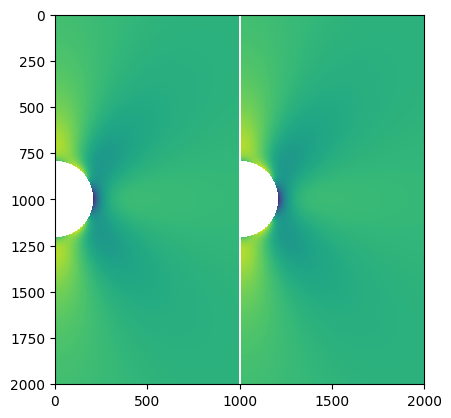

In [22]:
plt.imshow(sigmay)

In [18]:
# Plotting
X = []
X[0:1001] = X2
X[1002:2002] = X1
[x, y] = np.meshgrid(X, Y2)

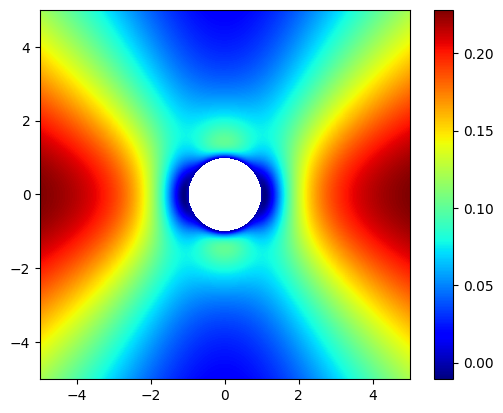

In [23]:
plt.pcolor(x,y,radial1,cmap='jet')
plt.gca().set_aspect('equal')
plt.colorbar()
plt.show()